In [1]:
# Install libraries

%%capture

! pip install gdown
! pip install mlxtend # association rule mining library in Python

In [2]:
# Download the dataset

%%capture

! rm -rf *
! gdown --id 1wkueGBj7yXkOpjO0naBAjqUYIliUTuJf 
! unzip supermarket.zip
! rm supermarket.zip

In [3]:
# Import libraries

%%capture

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder  

# Show plots inside the jupyter notebook
%matplotlib inline

In [4]:
# Read the dataset

df = pd.read_csv("supermarket.csv")

# Add extra columns

df["Date"] = pd.to_datetime(df["Date"])
df["extra_date"] = df["Date"]
df["year"] = df['Date'].dt.year
df["weekday"] = df['Date'].dt.day_name()

# Set "Date" as index
df = df.set_index(['Date'])

print(f"Number of rows are: {df.shape[0]}")

df.head()

Number of rows are: 32710


,Customer Id,Product,extra_date,year,weekday
Date,,,,,
2020-07-20,JKML5ZWXP0XQ,tropical fruit,2020-07-20,2020,Monday
2020-04-30,YOGWQIUPDAJ7,whole milk,2020-04-30,2020,Thursday
2020-09-18,Q3NL22281AF6,pip fruit,2020-09-18,2020,Friday
2020-12-11,C59GRTLMZQAU,other vegetables,2020-12-11,2020,Friday
2020-01-02,WUSF8LTEQZ5L,whole milk,2020-01-02,2020,Thursday


# Exploration Questions

In [5]:
# Q1 - Number of unique products
unique_products = df.Product.nunique()
print("There are {} unique products sold ".format(unique_products))

There are 137 unique products sold 


In [6]:
# Q2 - Average number of sold products per day
total_days = df.index.nunique()
total_products = len(df)
average_products = total_products / total_days

print("With an average of {:.2f} items sold daily".format(average_products))

With an average of 44.93 items sold daily


In [7]:
# Q3 - Which products were sold less than others?

df.Product.value_counts().tail(5).sort_values()

preservation products    1
kitchen utensil          1
baby cosmetics           3
bags                     4
toilet cleaner           5
Name: Product, dtype: int64

In [8]:
# Q4 - Top 5 customers with highest number of baskets in 2020
df[df.year==2020].groupby("Customer Id")["extra_date"].nunique().sort_values(ascending=False).head(6)

Customer Id
QBUS9NZY39BE    7
0ZRF32AJ06BC    7
M722MPITBY07    7
M2DT2Z00NQCH    7
E7FD9BU4OK0F    7
WR2HDQL7MDVM    6
Name: extra_date, dtype: int64

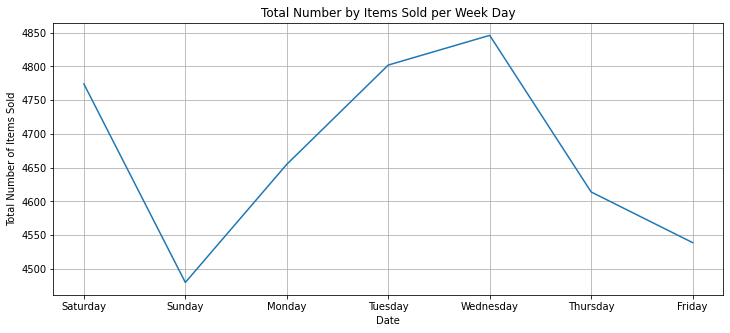

In [9]:
# Q5 - Day with the highest number of sold products

custom_dict = {"Saturday": 1, "Sunday": 2, "Monday": 3, "Tuesday": 4, "Wednesday": 5, "Thursday": 6, "Friday": 7}

df.groupby("weekday")["Product"].count().sort_index(key=lambda x: x.map(custom_dict)).plot(figsize=(12,5), grid=True, title="Total Number by Items Sold per Week Day").set(xlabel="Date", ylabel="Total Number of Items Sold");

# Association Rule Mining Question

In [10]:
# Create transaction list

transactions = [record[1]['Product'].tolist() for record in list(df.groupby(['Customer Id','Date']))]
transactions

[['rolls/buns', 'brown bread', 'dessert'],
 ['root vegetables', 'flour'],
 ['salty snack', 'bottled beer'],
 ['domestic eggs'],
 ['white bread'],
 ['rolls/buns', 'sauces'],
 ['white bread'],
 ['frozen fish', 'whole milk'],
 ['baking powder', 'soda'],
 ['whole milk'],
 ['long life bakery product', 'hard cheese'],
 ['waffles', 'pudding powder'],
 ['grapes', 'hard cheese'],
 ['root vegetables', 'white bread'],
 ['yogurt', 'butter milk'],
 ['ketchup'],
 ['curd', 'processed cheese'],
 ['root vegetables', 'grapes', 'white bread', 'dishes'],
 ['tropical fruit'],
 ['turkey', 'whole milk', 'citrus fruit', 'pastry', 'soda'],
 ['organic sausage', 'UHT-milk'],
 ['rolls/buns'],
 ['pip fruit', 'root vegetables'],
 ['whole milk', 'finished products', 'beef'],
 ['rolls/buns', 'sliced cheese'],
 ['other vegetables', 'frozen meals'],
 ['whole milk', 'candy'],
 ['citrus fruit', 'whole milk', 'sliced cheese'],
 ['chicken', 'rolls/buns'],
 ['chicken', 'rolls/buns'],
 ['pip fruit', 'hamburger meat', 'butter

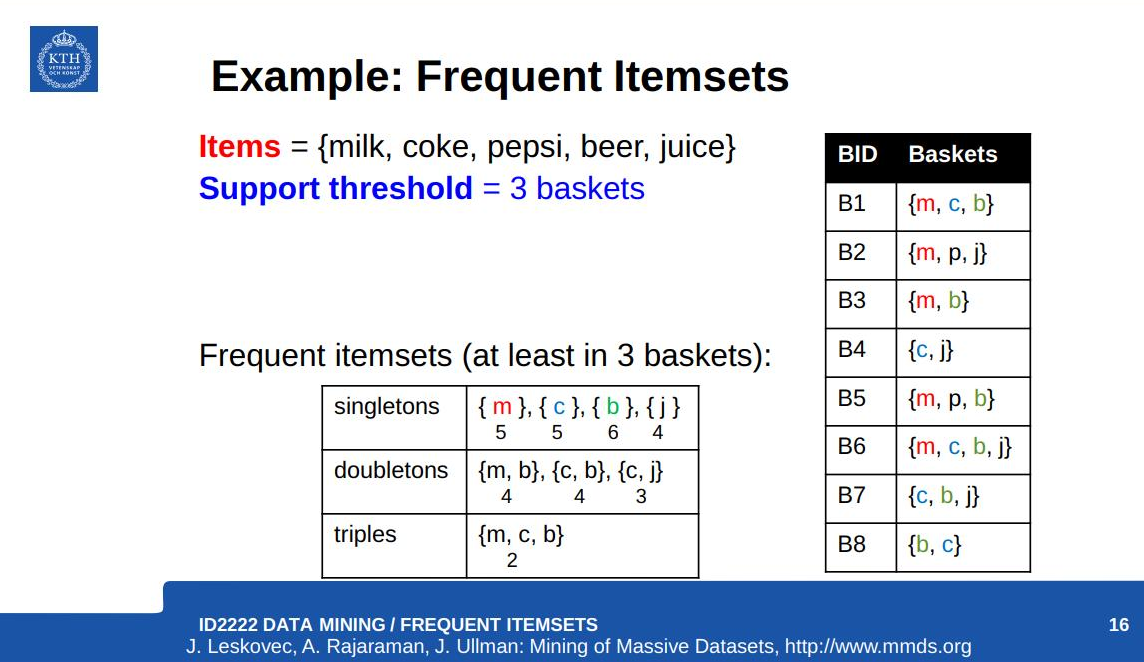

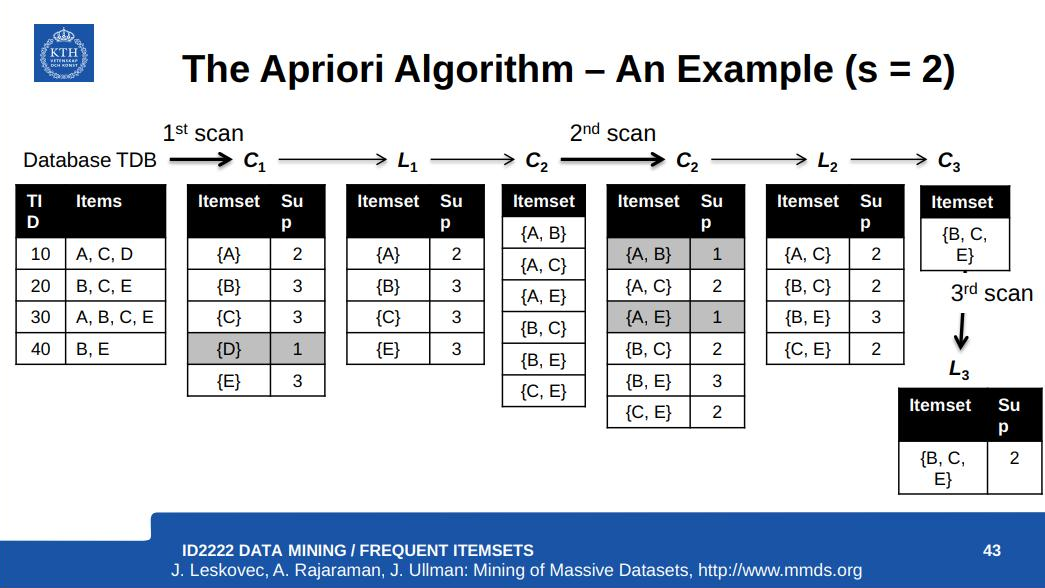

In [11]:
# http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

baskets = pd.DataFrame(te_ary, columns=te.columns_)
baskets

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brown bread,butter,butter milk,cake bar,candles,candy,canned fish,canned fruit,canned vegetables,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,curd,curd cheese,decalcifier,dental care,dessert,...,pudding powder,ready soups,rice,roll products,rolls/buns,root vegetables,salad dressing,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,soups,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,tea,toilet cleaner,tropical fruit,turkey,waffles,whipped/sour cream,white bread,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14748,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False

In [12]:
# Q6 - Calculate "support"

freq_items = apriori(baskets, min_support=0.01, use_colnames=True)
freq_items['length'] = freq_items['itemsets'].apply(lambda x: len(x))

freq_items.sort_values(by="support", ascending=False).head(5)

,support,itemsets,length
51,0.160171,(whole milk),1
33,0.123839,(other vegetables),1
37,0.111571,(rolls/buns),1
42,0.098488,(soda),1
52,0.087101,(yogurt),1


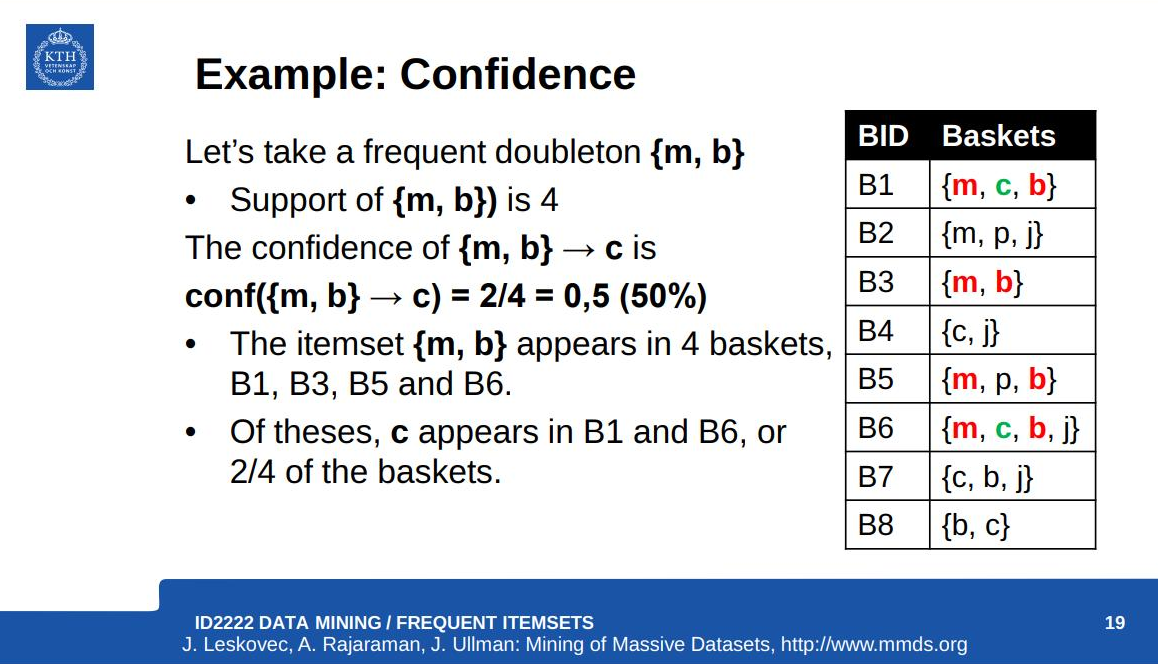

In [19]:
# Q7 - Calculate "confidence"

rules = association_rules(freq_items, metric="confidence", min_threshold=0)

rules[["antecedents","consequents","support","confidence"]].sort_values(by="confidence", ascending=False).head(5)

,antecedents,consequents,support,confidence
9,(yogurt),(whole milk),0.011320,0.129961
4,(rolls/buns),(whole milk),0.014167,0.126974
3,(other vegetables),(whole milk),0.015048,0.121511
7,(soda),(whole milk),0.011794,0.119752
0,(rolls/buns),(other vegetables),0.010710,0.095990
